In [ ]:
import sys
import math
import random
import warnings
import numpy as np
from sklearn import svm
import keras.backend as K
from keras.models import Model
from theano import tensor as T
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Add
from keras.engine.topology import Layer
from sklearn.metrics import accuracy_score
from keras.layers import Dropout
from keras.layers.core import  Activation, Dense, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Conv2DTranspose

In [ ]:
warnings.simplefilter("ignore")

HIDDEN_DIM_1 = 500
HIDDEN_DIM_2 = 300
HIDDEN_DIM_3 = 50      
EPOCHS = 100
BATCH_SIZE = 100
IMG_DIM = 392         
LAMBDA_1 = 0.02
LAMBDA_2 = 0.001
LAMBDA_3 = 0.05

In [ ]:
class ZeroPadding(Layer):
    def __init__(self, **kwargs):
        super(ZeroPadding, self).__init__(**kwargs)

    def call(self, x, mask=None):
        return K.zeros_like(x)

    def get_output_shape_for(self, input_shape):
        return input_shape

In [ ]:
# Custom layer for finding MSE in L4 and L5 losses
class MSE_Loss_Calculator(Layer):
    def __init__(self, **kwargs):
        super(MSE_Loss_Calculator, self).__init__(**kwargs)

    def call(self, x, mask=None):
        return K.mean(K.square(x[0] - x[1]), axis=-1)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0],input_shape[0][1])

In [ ]:
# Custom layer for finding Correlation loss in L6 and L7 losses
class Correlation_Loss_Calculator(Layer):
    def __init__(self, LAMBDA, **kwargs):
        super(Correlation_Loss_Calculator, self).__init__(**kwargs)
        self.LAMBDA = LAMBDA

    def call(self, x, y, mask=None):
        x_center = x - K.mean(x, axis=0)
        y_center = y - K.mean(y, axis=0)
        corr_dr = K.sqrt(K.sum(x_center * x_center, axis=0) + 1e-8) * K.sqrt(K.sum(y_center * y_center, axis=0) + 1e-8)
        return K.sum((K.sum(x_center * y_center, axis=0)) / corr_dr) * self.LAMBDA

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0],input_shape[0][1])

In [ ]:
# dummy loss functions -> actual loss is calculated using MSE_Loss_Calculator and Correlation_Loss_Calculator above

def mse_loss(y_true, y_pred):
    return y_pred

def corr_loss(y_true, y_pred):
    return y_pred

In [ ]:
def encode(x):

    x = Reshape((28,14,1))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(49, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)

    hidden_out_1 = Dense(HIDDEN_DIM_1,activation='sigmoid')(x)
    hidden_out_2 = Dense(HIDDEN_DIM_2, activation='sigmoid')(hidden_out_1)
    out = Dense(HIDDEN_DIM_3, activation='sigmoid')(hidden_out_2)

    return hidden_out_1, hidden_out_2, out

def decode(x):

    x = Dense(HIDDEN_DIM_2,activation='sigmoid')(x)
    x = Dense(HIDDEN_DIM_1, activation='sigmoid')(x)
    x = Dense(IMG_DIM, activation='sigmoid')(x)

    x = Reshape((4, 2, 49))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 1), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (1, 2), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(392, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
    x = Reshape((IMG_DIM,))(x)

    return x

def get_model():
    
    # Notations Used:
    # 1 = 1st hidden layer, 2 = 2nd hidden layer 
    # a = first view, b = second view

    inpx = Input(shape=(IMG_DIM,))
    inpy = Input(shape=(IMG_DIM,))

    # Encoding part
    # For first view
    hidden_out_1a, hidden_out_2a, out_a = encode(inpx)
    
    # For second view
    hidden_out_1b, hidden_out_2b, out_b = encode(inpy)

    # Joint common representation
    combined_out =  Add()([out_a, out_b]) 
    
    # Decoding
    rec_a = decode(combined_out)
    rec_b = decode(combined_out)   
    
    # Model after the encoding stage
    intermediate_model = Model([inpx,inpy],[rec_a, rec_b, combined_out, hidden_out_1a, hidden_out_1b, hidden_out_2a, hidden_out_2b])

    # for left view of image (x_i in paper)
    [rec_xa,rec_xb,hX,hx_1a,hx_1b,hx_2a,hx_2b] = intermediate_model([inpx, ZeroPadding()(inpy)])
    [rec_ya,rec_yb,hY,hy_1a,hy_1b,hy_2a,hy_2b] = intermediate_model([ZeroPadding()(inpx), inpy ])
    [rec_za,rec_zb,hZ,hz_1a,hz_1b,hz_2a,hz_2b] = intermediate_model([inpx, inpy])
    
    l4_loss_1a = MSE_Loss_Calculator()([hx_1a, hy_1a])
    l4_loss_1b = MSE_Loss_Calculator()([hx_1b, hy_1b])
    l4_loss_2a = MSE_Loss_Calculator()([hx_2a, hy_2a])
    l4_loss_2b = MSE_Loss_Calculator()([hx_2b, hy_2b])

    l5_loss_a = MSE_Loss_Calculator()([rec_xa, rec_ya])
    l5_loss_b = MSE_Loss_Calculator()([rec_xb, rec_yb])

    l6_loss = Correlation_Loss_Calculator(-LAMBDA_1)(hX,hY)

    l7_loss_1 = Correlation_Loss_Calculator(-LAMBDA_2)(hz_1a,hz_1b)
    l7_loss_2 = Correlation_Loss_Calculator(-LAMBDA_3)(hz_2a,hz_2b)

    # rec_za, rec_zb -> take L1 loss of these
    # rec_xa, rec_xb -> take L2 loss of these
    # rec_ya, rec_yb -> take L3 loss of these
    model = Model([inpx,inpy],[rec_za, rec_zb, rec_xa, rec_xb, rec_ya, rec_yb, l4_loss_1a, l4_loss_1b, l4_loss_2a, l4_loss_2b, l5_loss_a, l5_loss_b, l6_loss, l7_loss_1, l7_loss_2])
    model.compile(loss=["mse","mse","mse","mse","mse","mse",mse_loss,mse_loss,mse_loss,mse_loss,mse_loss,mse_loss,corr_loss,corr_loss,corr_loss], optimizer="adam")
    
    return model, intermediate_model

In [ ]:
def get_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    X_train_l = x_train[:, :, :14]
    X_train_r = x_train[:, :, 14:]
    X_test_l = x_test[:, :, :14]
    X_test_r = x_test[:, :, 14:]
    
    return X_train_l, X_train_r, y_train, X_test_l, X_test_r, y_test

In [ ]:
def visualize(left_view, right_view, y_train):

  for i in range(4):
    plt.subplot(1, 2, 1)
    left = left_view[i]
    pixels = np.array(left, dtype='uint8')
    pixels = pixels.reshape((28, 14))
    plt.title('Label is {label}'.format(label=y_train[i]))
    plt.imshow(pixels, cmap='gray')

    plt.subplot(1, 2, 2)
    right = right_view[i]
    pixels = np.array(right, dtype='uint8')
    pixels = pixels.reshape((28, 14))
    plt.title('Label is {label}'.format(label=y_train[i]))
    plt.imshow(pixels, cmap='gray')

    plt.show()

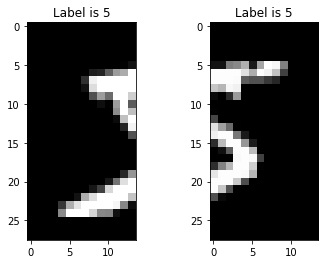

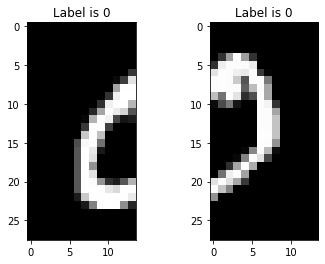

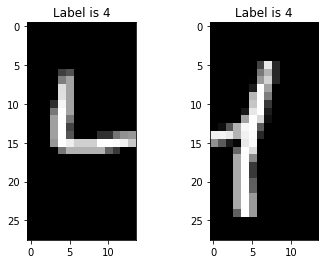

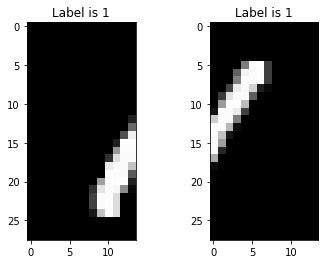

In [ ]:
train_left, train_right, y_train, test_left, test_right, y_test = get_data()

visualize(train_left, train_right, y_train)

In [ ]:
train_left = train_left.reshape(-1, IMG_DIM)
train_right = train_right.reshape(-1, IMG_DIM)

test_left = test_left.reshape(-1, IMG_DIM)
test_right = test_right.reshape(-1, IMG_DIM)

In [ ]:
model, intermediate_model = get_model()

print(intermediate_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 392)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 392)]        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 14, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 28, 14, 1)    0           input_4[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.fit([train_left,train_right], [train_left, train_right, 
                                     train_left, train_right, 
                                     train_left, train_right,
                                     np.zeros((train_left.shape[0],HIDDEN_DIM_1)), np.zeros((train_left.shape[0],HIDDEN_DIM_1)), np.zeros((train_left.shape[0],HIDDEN_DIM_2)), np.zeros((train_left.shape[0],HIDDEN_DIM_2)),
              np.zeros((train_left.shape)), np.zeros((train_left.shape)),
              np.zeros((train_left.shape[0],HIDDEN_DIM_3)), 
              np.zeros((train_left.shape[0],HIDDEN_DIM_1)),np.zeros((train_left.shape[0],HIDDEN_DIM_2))],
              epochs = EPOCHS, batch_size = BATCH_SIZE, verbose=1)

Epoch 1/100
600/600 [==============================] - 88s 87ms/step - loss: 27050.1467 - model_loss: 4199.7137 - model_1_loss: 4805.6218 - model_2_loss: 4197.9283 - model_3_loss: 4821.0427 - model_4_loss: 4209.3350 - model_5_loss: 4802.5580 - mse__loss__calculator_loss: 0.0953 - mse__loss__calculator_1_loss: 0.0990 - mse__loss__calculator_2_loss: 0.0499 - mse__loss__calculator_3_loss: 0.0515 - mse__loss__calculator_4_loss: 11.0663 - mse__loss__calculator_5_loss: 16.0811 - correlation__loss__calculator_loss: -0.8203 - correlation__loss__calculator_1_loss: -0.2008 - correlation__loss__calculator_2_loss: -12.4817
Epoch 2/100
600/600 [==============================] - 52s 87ms/step - loss: 21854.0795 - model_loss: 3401.7707 - model_1_loss: 3775.2884 - model_2_loss: 3365.7271 - model_3_loss: 3857.2590 - model_4_loss: 3452.1092 - model_5_loss: 3732.8706 - mse__loss__calculator_loss: 0.2333 - mse__loss__calculator_1_loss: 0.2521 - mse__loss__calculator_2_loss: 0.1534 - mse__loss__calculator_

In [ ]:
def test(direction, model, inp, idx):
    given = inp.reshape((28,14))
    f, axarr = plt.subplots(1,2,sharey=False)
    
    plt.title(y_test[idx])

    if(direction == 'left'):
      pred = model.predict([inp,np.zeros_like(inp)])
      axarr[0].imshow(given)
      axarr[1].imshow(pred[0].reshape((28,14)))

    else:
      pred = model.predict([np.zeros_like(inp),inp])
      axarr[1].imshow(given)
      axarr[0].imshow(pred[1].reshape((28,14)))

Right to Left testing


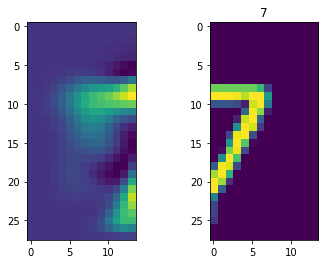

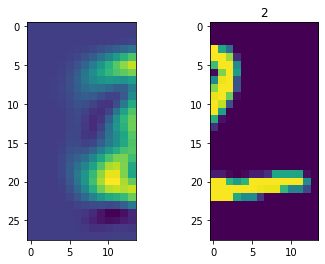

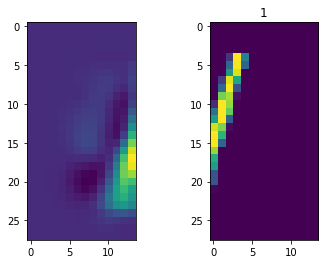

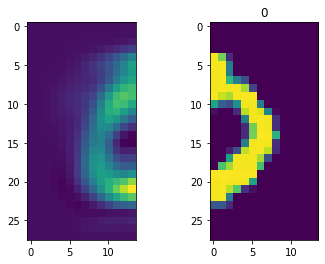

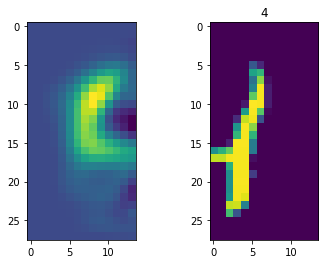

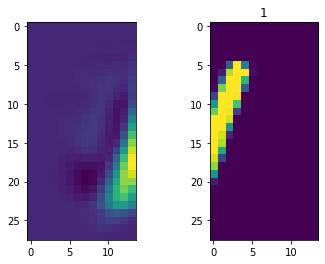

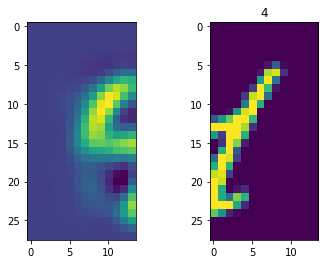

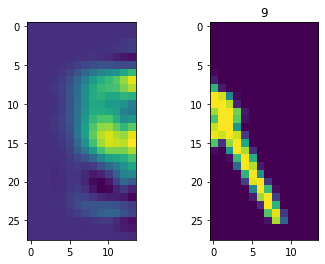

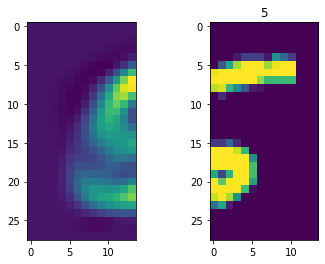

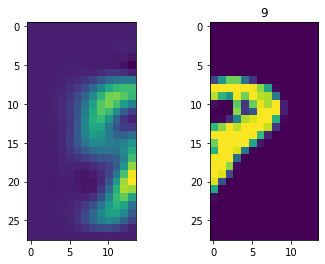

In [ ]:
print('Right to Left testing')
for i in range(10):
  test('right', model, test_right[i:i+1], i)